# Import Lib


In [2]:
import pandas as pd
import numpy as np
import random
import math
import time
import collections
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

# RF From Scratch https://github.com/zhaoxingfeng/RandomForest

In [3]:
# -*- coding: utf-8 -*-
"""
@Env: Python2.7
@Time: 2019/10/24 13:31
@Author: zhaoxingfeng
@Function：Random Forest（RF），随机森林二分类
@Version: V1.2
参考文献：
[1] UCI. wine[DB/OL].https://archive.ics.uci.edu/ml/machine-learning-databases/wine.
"""

class Tree(object):
    """Define a decision tree"""
    def __init__(self):
        self.split_feature = None
        self.split_value = None
        self.leaf_value = None
        self.tree_left = None
        self.tree_right = None

    def calc_predict_value(self, dataset):
        """Find the leaf node of the sample through the recursive decision tree"""
        if self.leaf_value is not None:
            return self.leaf_value
        elif dataset[self.split_feature] <= self.split_value:
            return self.tree_left.calc_predict_value(dataset)
        else:
            return self.tree_right.calc_predict_value(dataset)

    def describe_tree(self):
        """
        Print the decision tree in json form, 
        which is convenient for viewing the tree structure
        """
        if not self.tree_left and not self.tree_right:
            leaf_info = "{leaf_value:" + str(self.leaf_value) + "}"
            return leaf_info
        left_info = self.tree_left.describe_tree()
        right_info = self.tree_right.describe_tree()
        tree_structure = "{split_feature:" + str(self.split_feature) + \
                         ",split_value:" + str(self.split_value) + \
                         ",left_tree:" + left_info + \
                         ",right_tree:" + right_info + "}"
        return tree_structure

In [4]:
class RandomForestClassifier(object):
    def __init__(self, n_estimators=10, max_depth=-1, min_samples_split=2, min_samples_leaf=1,
                 min_split_gain=0.0, colsample_bytree=None, subsample=0.8, random_state=None):
        """
        Random Forest Parameters
         ----------
         n_estimators: 
              number of trees
         max_depth: 
              tree depth, -1 means unlimited depth
         min_samples_split: 
              The minimum number of samples required for node splitting, 
              the node terminates splitting if it is less than this value
         min_samples_leaf: 
              The minimum sample number of leaf nodes, 
              less than this value leaves are merged
         min_split_gain: 
              The minimum gain required for splitting, 
              less than this value the node terminates the split
         colsample_bytree: 
              Column sampling setting, which can be [sqrt, log2]. 
              sqrt means randomly selecting sqrt(n_features) features,
              log2 means to randomly select log(n_features) features, 
              if set to other, column sampling will not be performed
         subsample: 
              line sampling ratio
         random_state: 
              Random seed, after setting, 
              the n_estimators sample sets generated each time will not change, 
              ensuring that the experiment can be repeated
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth if max_depth != -1 else float('inf')
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_split_gain = min_split_gain
        self.colsample_bytree = colsample_bytree
        self.subsample = subsample
        self.random_state = random_state
        self.trees = None
        self.feature_importances_ = dict()

    def fit(self, dataset, targets):
        """Model training entry"""
        assert targets.unique().__len__() == 2, "There must be two class for targets!"
        targets = targets.to_frame(name='label')

        if self.random_state:
            random.seed(self.random_state)
        random_state_stages = random.sample(range(self.n_estimators), self.n_estimators)

        # Two column sampling methods
        if self.colsample_bytree == "sqrt":
            self.colsample_bytree = int(len(dataset.columns) ** 0.5)
        elif self.colsample_bytree == "log2":
            self.colsample_bytree = int(math.log(len(dataset.columns)))
        else:
            self.colsample_bytree = len(dataset.columns)

        # Build multiple decision trees in parallel
        self.trees = Parallel(n_jobs=-1, verbose=0, backend="threading")(
            delayed(self._parallel_build_trees)(dataset, targets, random_state)
                for random_state in random_state_stages)
        
    def _parallel_build_trees(self, dataset, targets, random_state):
        """
        bootstrap has put back sampling to 
        generate a training sample set and build a decision tree
        """
        subcol_index = random.sample(dataset.columns.tolist(), self.colsample_bytree)
        dataset_stage = dataset.sample(n=int(self.subsample * len(dataset)), replace=True, 
                                        random_state=random_state).reset_index(drop=True)
        dataset_stage = dataset_stage.loc[:, subcol_index]
        targets_stage = targets.sample(n=int(self.subsample * len(dataset)), replace=True, 
                                        random_state=random_state).reset_index(drop=True)

        tree = self._build_single_tree(dataset_stage, targets_stage, depth=0)

        # -------------- PRINT BEST NODE --------------
        # print(tree.describe_tree())

        return tree

    def _build_single_tree(self, dataset, targets, depth):
        """Recursively build a decision tree"""
        # If the categories of the node 
        # are all the same/the samples are less than 
        # the minimum number of samples required for splitting, 
        # select the category with the most occurrences. 
        # Termination of division/split
        if len(targets['label'].unique()) <= 1 or dataset.__len__() <= self.min_samples_split:
            tree = Tree()
            tree.leaf_value = self.calc_leaf_value(targets['label'])
            return tree

        if depth < self.max_depth:
            best_split_feature, best_split_value, best_split_gain = self.choose_best_feature(dataset, targets)
            left_dataset, right_dataset, left_targets, right_targets = \
                self.split_dataset(dataset, targets, best_split_feature, best_split_value)

            tree = Tree()
            # If after the parent node is split, 
            # the left leaf node/right leaf node sample is less than 
            # the set minimum number of leaf node samples, 
            # the parent node will terminate the split
            if left_dataset.__len__() <= self.min_samples_leaf or \
                    right_dataset.__len__() <= self.min_samples_leaf or \
                    best_split_gain <= self.min_split_gain:
                tree.leaf_value = self.calc_leaf_value(targets['label'])
                return tree
            else:
                # If this feature is used when splitting, 
                # the importance of this feature will be increased by 1
                self.feature_importances_[best_split_feature] = \
                    self.feature_importances_.get(best_split_feature, 0) + 1

                tree.split_feature = best_split_feature
                tree.split_value = best_split_value
                tree.tree_left = self._build_single_tree(left_dataset, left_targets, depth+1)
                tree.tree_right = self._build_single_tree(right_dataset, right_targets, depth+1)
                return tree
        # If the depth of the tree exceeds the preset value, terminate the split
        else:
            tree = Tree()
            tree.leaf_value = self.calc_leaf_value(targets['label'])
            return tree

    def choose_best_feature(self, dataset, targets):
        """
        Find the best data set division method, 
        find the optimal split feature, 
        split threshold, split gain
        """
        best_split_gain = 1
        best_split_feature = None
        best_split_value = None

        for feature in dataset.columns:
            if dataset[feature].unique().__len__() <= 100:
                unique_values = sorted(dataset[feature].unique().tolist())
            # If the dimension feature has too many values, 
            # select the 100th percentile value as the split threshold to be selected
            else:
                unique_values = np.unique([np.percentile(dataset[feature], x)
                                           for x in np.linspace(0, 100, 100)])

            # Calculate the splitting gain for the possible splitting thresholds, 
            # and select the threshold with the largest gain
            for split_value in unique_values:
                left_targets = targets[dataset[feature] <= split_value]
                right_targets = targets[dataset[feature] > split_value]
                split_gain = self.calc_gini(left_targets['label'], right_targets['label'])

                if split_gain < best_split_gain:
                    best_split_feature = feature
                    best_split_value = split_value
                    best_split_gain = split_gain
        return best_split_feature, best_split_value, best_split_gain

    @staticmethod
    def calc_leaf_value(targets):
        """
        Select the category with the most occurrences 
        in the sample as the value of the leaf node
        """
        label_counts = collections.Counter(targets)
        major_label = max(zip(label_counts.values(), label_counts.keys()))
        return major_label[1]

    @staticmethod
    def calc_gini(left_targets, right_targets):
        """
        The classification tree uses the Gini index as an 
        indicator to select the optimal split point
        """
        split_gain = 0
        for targets in [left_targets, right_targets]:
            gini = 1
            # Count how many samples are in each category, 
            # and then calculate gini
            label_counts = collections.Counter(targets)
            for key in label_counts:
                prob = label_counts[key] * 1.0 / len(targets)
                gini -= prob ** 2
            split_gain += len(targets) * 1.0 / (len(left_targets) + len(right_targets)) * gini
        return split_gain

    @staticmethod
    def split_dataset(dataset, targets, split_feature, split_value):
        """
        Divide the sample into left and right parts according to the 
        characteristics and threshold, the left is less than or 
        equal to the threshold, and the right is greater than the threshold
        """
        left_dataset = dataset[dataset[split_feature] <= split_value]
        left_targets = targets[dataset[split_feature] <= split_value]
        right_dataset = dataset[dataset[split_feature] > split_value]
        right_targets = targets[dataset[split_feature] > split_value]
        return left_dataset, right_dataset, left_targets, right_targets

    def predict(self, dataset):
        """Input sample, predict category"""
        res = []
        for _, row in dataset.iterrows():
            pred_list = []
            # Count the prediction results of each tree, 
            # and select the result with the most occurrences 
            # as the final category
            for tree in self.trees:
                pred_list.append(tree.calc_predict_value(row))

            pred_label_counts = collections.Counter(pred_list)
            pred_label = max(zip(pred_label_counts.values(), pred_label_counts.keys()))
            res.append(pred_label[1])
        return np.array(res)

Hyperparameter Grid Search

In [ ]:
if __name__ == '__main__':
    phenotype_resistance = ['emb','inh','pza','rif']

    # print("res_type short name list : emb, inh, pza, rif")
    # resistance_type = input("insert resistance type short name!\n")

    # Read dataset.csv into dataframe
    for resistance_type in phenotype_resistance:

      dataFrame = pd.read_csv(f'amr_datasets_r_{resistance_type}.csv')

      # Drop phen_r_inh and accession_number feature (duplicate class in dataset.csv)
      dataFrame = dataFrame.drop(f'phen_r_{resistance_type}', axis=1)
      dataFrame = dataFrame.drop('!accession', axis=1)

      # create LabelEncoder object
      label_encoder = LabelEncoder()

      # fit and transform the categorical variable
      dataFrame['line_age'] = label_encoder.fit_transform(dataFrame['line_age'])


      # df = pd.read_csv("wine.txt")
      # df = df[df['label'].isin([1, 2])].sample(frac=1, random_state=66).reset_index(drop=True)
      # print("df\n",df)

      opt_n_estimators = [5,10,25,50,100]
      opt_max_depth = [10,25,50,75,100]
      opt_random_state = [2,8,16,32,64]
      opt_min_samples_split = [10,20,30,40,50]

      arr_acc_train = []
      arr_acc_test = []

      for p1,p2,p3,p4 in zip(
          opt_n_estimators, 
          opt_max_depth, 
          opt_random_state, 
          opt_min_samples_split
          ):

        clf = RandomForestClassifier(n_estimators=p1,
                                    max_depth=p2,
                                    min_samples_split=p4,
                                    min_samples_leaf=2,
                                    min_split_gain=0.0,
                                    colsample_bytree="sqrt",
                                    subsample=0.8,
                                    random_state=p3)

        x, y = dataFrame.iloc[:, :-1], dataFrame.iloc[:, -1]

        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=0.3, random_state=random.randint(1, 25)
        )

        clf.fit(x_train, y_train)

        from sklearn import metrics
        print("-------MODEL",resistance_type,"with Parameter:",p1,p2,p3,p4,"-------")
        print(metrics.accuracy_score(y_train, clf.predict(x_train)))
        print(metrics.accuracy_score(y_test, clf.predict(x_test)))

        arr_acc_train.append(metrics.accuracy_score(y_train, clf.predict(x_train)))
        arr_acc_test.append(metrics.accuracy_score(y_test, clf.predict(x_test)))

      print("-------MODEL",resistance_type,"-------")
      print(resistance_type,"model train_acc_result:",arr_acc_train)
      print(resistance_type,"model test_acc_result:",arr_acc_test)
      print(resistance_type,"model avg_train_acc:", np.average(np.array(arr_acc_train)))
      print(resistance_type,"model avg_test_acc:", np.average(np.array(arr_acc_test)),"\n\n")

-------MODEL emb with Parameter: 5 10 2 10 -------
0.7168141592920354
0.673469387755102
-------MODEL emb with Parameter: 10 25 8 20 -------
0.7168141592920354
0.7142857142857143
-------MODEL emb with Parameter: 25 50 16 30 -------
0.7345132743362832
0.6530612244897959
-------MODEL emb with Parameter: 50 75 32 40 -------
0.7345132743362832
0.6530612244897959
-------MODEL emb with Parameter: 100 100 64 50 -------
0.7079646017699115
0.6938775510204082
-------MODEL emb -------
emb model train_acc_result: [0.7168141592920354, 0.7168141592920354, 0.7345132743362832, 0.7345132743362832, 0.7079646017699115]
emb model test_acc_result: [0.673469387755102, 0.7142857142857143, 0.6530612244897959, 0.6530612244897959, 0.6938775510204082]
emb model avg_train_acc: 0.7221238938053098
emb model avg_test_acc: 0.6775510204081632 


-------MODEL inh with Parameter: 5 10 2 10 -------
0.7130434782608696
0.5
-------MODEL inh with Parameter: 10 25 8 20 -------
0.6956521739130435
0.64
-------MODEL inh with Para

USE Hyperparameter Grid Search + KFOLD

In [6]:
if __name__ == '__main__':
    phenotype_resistance = ['emb','inh','pza','rif']

    # print("res_type short name list : emb, inh, pza, rif")
    # resistance_type = input("insert resistance type short name!\n")

    result_type_gsearch_kcv_train = [[],[],[],[]]
    result_type_gsearch_avg_kcv_train = []
    result_type_avg_gsearch_train = []

    result_type_gsearch_kcv_test = [[],[],[],[]]
    result_type_gsearch_avg_kcv_test = []
    result_type_avg_gsearch_test = []

    # Read dataset.csv into dataframe
    for idx_res_type, resistance_type in enumerate(phenotype_resistance):

      dataFrame = pd.read_csv(f'amr_datasets_r_{resistance_type}.csv')

      # Drop phen_r_inh and accession_number feature (duplicate class in dataset.csv)
      dataFrame = dataFrame.drop(f'phen_r_{resistance_type}', axis=1)
      dataFrame = dataFrame.drop('!accession', axis=1)

      # create LabelEncoder object
      label_encoder = LabelEncoder()

      # fit and transform the categorical variable
      dataFrame['line_age'] = label_encoder.fit_transform(dataFrame['line_age'])


      # df = pd.read_csv("wine.txt")
      # df = df[df['label'].isin([1, 2])].sample(frac=1, random_state=66).reset_index(drop=True)
      # print("df\n",df)

      #---------Grid Search---------
      opt_n_estimators = [5,10,25]
      opt_max_depth = [10,25,50]
      opt_random_state = [2,8,16]
      opt_min_samples_split = [10,20,30]

      arr_acc_train = []
      arr_acc_test = []

      for p1,p2,p3,p4 in zip(
          opt_n_estimators, 
          opt_max_depth, 
          opt_random_state, 
          opt_min_samples_split
          ):

        fold_acc_train = []
        fold_acc_test = []

        clf = RandomForestClassifier(n_estimators=p1,
                                    max_depth=p2,
                                    min_samples_split=p4,
                                    min_samples_leaf=2,
                                    min_split_gain=0.0,
                                    colsample_bytree="sqrt",
                                    subsample=0.8,
                                    random_state=p3)

        x, y = dataFrame.iloc[:, :-1], dataFrame.iloc[:, -1]
        rand_state_int = random.randint(1, 25)

        #---------K-Fold_Crossvalidation---------
        kfold_cv = KFold(n_splits=10, 
                         random_state=rand_state_int,
                         shuffle=True)
        
        for i, (train_index, test_index) in enumerate(kfold_cv.split(x)):
          # print(f"Fold {i}:")
          # print(f"  Train idx={train_index}")
          # print(f"  Test idx={test_index}")
          x_train , x_test = x.iloc[train_index,:],x.iloc[test_index,:]
          y_train , y_test = y[train_index] , y[test_index]

          clf.fit(x_train, y_train)

          from sklearn import metrics
          print("-------MODEL",resistance_type,"with Parameter:",p1,p2,p3,p4,f"FOLD-{i}-------")
          print(f"Selected random state int : {rand_state_int}")
          print(metrics.accuracy_score(y_train, clf.predict(x_train)))
          print(metrics.accuracy_score(y_test, clf.predict(x_test)))

          fold_acc_train.append(metrics.accuracy_score(y_train, clf.predict(x_train)))
          fold_acc_test.append(metrics.accuracy_score(y_test, clf.predict(x_test)))

        result_type_gsearch_kcv_train[idx_res_type].append(fold_acc_train)
        result_type_gsearch_kcv_test[idx_res_type].append(fold_acc_test)

        print("-------MODEL",resistance_type,"with Parameter:",p1,p2,p3,p4,"FOLD AVG-------")
        print("Training AVG",np.average(np.array(fold_acc_train)))
        print("Test AVG",np.average(np.array(fold_acc_test)),"\n")
        arr_acc_train.append(np.average(np.array(fold_acc_train)))
        arr_acc_test.append(np.average(np.array(fold_acc_test)))

      result_type_gsearch_avg_kcv_train.append(arr_acc_train)
      result_type_gsearch_avg_kcv_test.append(arr_acc_test)
      print("-------MODEL",resistance_type,"-------")
      print(resistance_type,"model train_acc_result:",arr_acc_train)
      print(resistance_type,"model test_acc_result:",arr_acc_test)
      print(resistance_type,"model avg_train_acc:", np.average(np.array(arr_acc_train)))
      print(resistance_type,"model avg_test_acc:", np.average(np.array(arr_acc_test)),"\n\n\n")


      result_type_avg_gsearch_train.append(np.average(np.array(arr_acc_train)))
      result_type_avg_gsearch_test.append(np.average(np.array(arr_acc_test)))

-------MODEL emb with Parameter: 5 10 2 10 FOLD-0-------
Selected random state int : 23
0.696551724137931
0.8823529411764706
-------MODEL emb with Parameter: 5 10 2 10 FOLD-1-------
Selected random state int : 23
0.8344827586206897
0.8235294117647058
-------MODEL emb with Parameter: 5 10 2 10 FOLD-2-------
Selected random state int : 23
0.8013698630136986
0.875
-------MODEL emb with Parameter: 5 10 2 10 FOLD-3-------
Selected random state int : 23
0.821917808219178
0.625
-------MODEL emb with Parameter: 5 10 2 10 FOLD-4-------
Selected random state int : 23
0.7876712328767124
0.8125
-------MODEL emb with Parameter: 5 10 2 10 FOLD-5-------
Selected random state int : 23
0.815068493150685
0.8125
-------MODEL emb with Parameter: 5 10 2 10 FOLD-6-------
Selected random state int : 23
0.815068493150685
0.875
-------MODEL emb with Parameter: 5 10 2 10 FOLD-7-------
Selected random state int : 23
0.8356164383561644
0.6875
-------MODEL emb with Parameter: 5 10 2 10 FOLD-8-------
Selected rando

[[[0.696551724137931, 0.8344827586206897, 0.8013698630136986, 0.821917808219178, 0.7876712328767124, 0.815068493150685, 0.815068493150685, 0.8356164383561644, 0.8013698630136986, 0.8082191780821918], [0.6896551724137931, 0.8275862068965517, 0.7945205479452054, 0.8013698630136986, 0.7945205479452054, 0.8287671232876712, 0.8287671232876712, 0.821917808219178, 0.815068493150685, 0.7876712328767124], [0.7310344827586207, 0.8, 0.8013698630136986, 0.8356164383561644, 0.815068493150685, 0.7808219178082192, 0.8013698630136986, 0.815068493150685, 0.7876712328767124, 0.815068493150685]], [[0.6621621621621622, 0.918918918918919, 0.9256756756756757, 0.9459459459459459, 0.9256756756756757, 0.9261744966442953, 0.9328859060402684, 0.9194630872483222, 0.9328859060402684, 0.9194630872483222], [0.6891891891891891, 0.9256756756756757, 0.9256756756756757, 0.9324324324324325, 0.9324324324324325, 0.9395973154362416, 0.9261744966442953, 0.9194630872483222, 0.9194630872483222, 0.912751677852349], [0.743243243

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0 [0.6621621621621622, 0.918918918918919, 0.9256756756756757, 0.9459459459459459, 0.9256756756756757, 0.9261744966442953, 0.9328859060402684, 0.9194630872483222, 0.9328859060402684, 0.9194630872483222]
1 [0.6891891891891891, 0.9256756756756757, 0.9256756756756757, 0.9324324324324325, 0.9324324324324325, 0.9395973154362416, 0.9261744966442953, 0.9194630872483222, 0.9194630872483222, 0.912751677852349]
2 [0.7432432432432432, 0.9256756756756757, 0.918918918918919, 0.9256756756756757, 0.9121621621621622, 0.9328859060402684, 0.9261744966442953, 0.9328859060402684, 0.9261744966442953, 0.9261744966442953]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0 [0.9241379310344827, 0.9310344827586207, 0.910958904109589, 0.9178082191780822, 0.9178082191780822, 0.9315068493150684, 0.910958904109589, 0.910958904109589, 0.9315068493150684, 0.910958904109589]
1 [0.9241379310344827, 0.9103448275862069, 0.910958904109589, 0.9178082191780822, 0.9315068493150684, 0.910958904109589, 0.9315068493150684, 0.910958904109589, 0.9246575342465754, 0.9246575342465754]
2 [0.9172413793103448, 0.9172413793103448, 0.9246575342465754, 0.9178082191780822, 0.9246575342465754, 0.9315068493150684, 0.9178082191780822, 0.910958904109589, 0.9178082191780822, 0.9178082191780822]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0 [0.8493150684931506, 0.8287671232876712, 0.8287671232876712, 0.8231292517006803, 0.8367346938775511, 0.8435374149659864, 0.8231292517006803, 0.8299319727891157, 0.8503401360544217, 0.8435374149659864]
1 [0.8287671232876712, 0.821917808219178, 0.8424657534246576, 0.8367346938775511, 0.8435374149659864, 0.8503401360544217, 0.8231292517006803, 0.8367346938775511, 0.8435374149659864, 0.8639455782312925]
2 [0.821917808219178, 0.8424657534246576, 0.8356164383561644, 0.8299319727891157, 0.8367346938775511, 0.8367346938775511, 0.8367346938775511, 0.8299319727891157, 0.8435374149659864, 0.8299319727891157]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

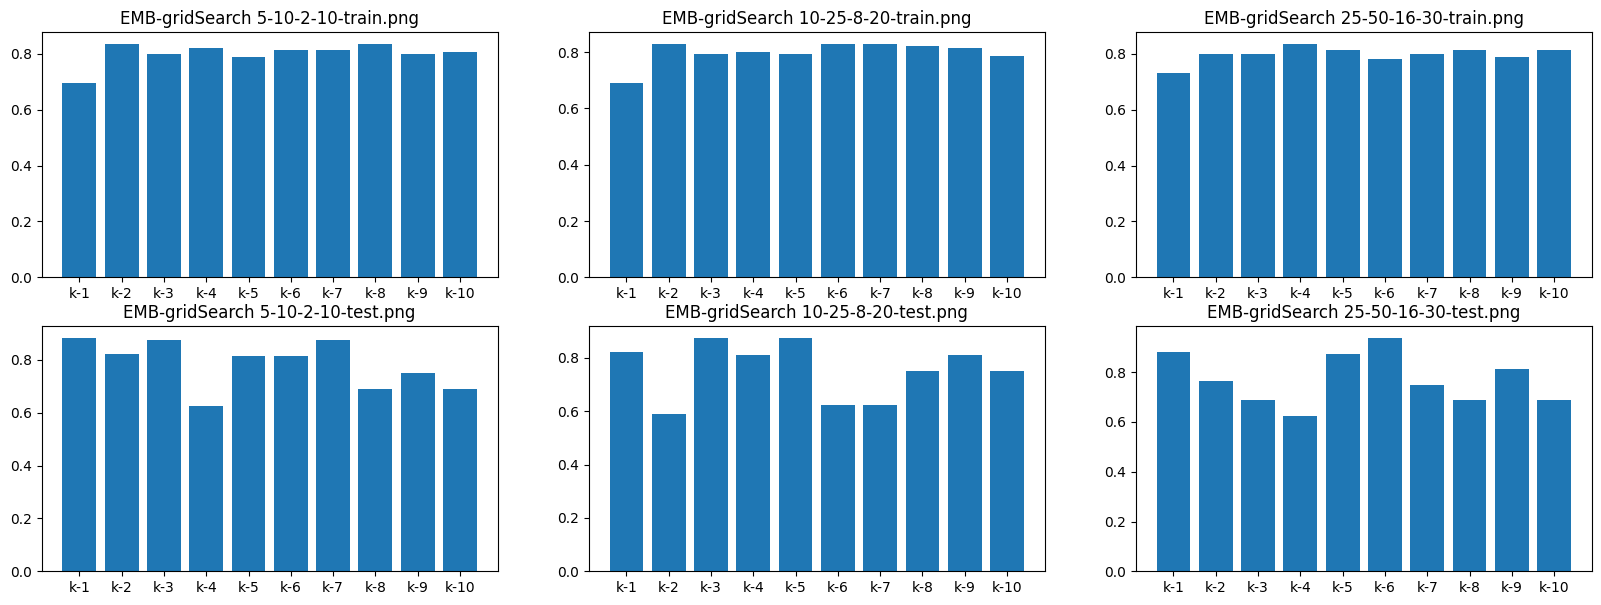

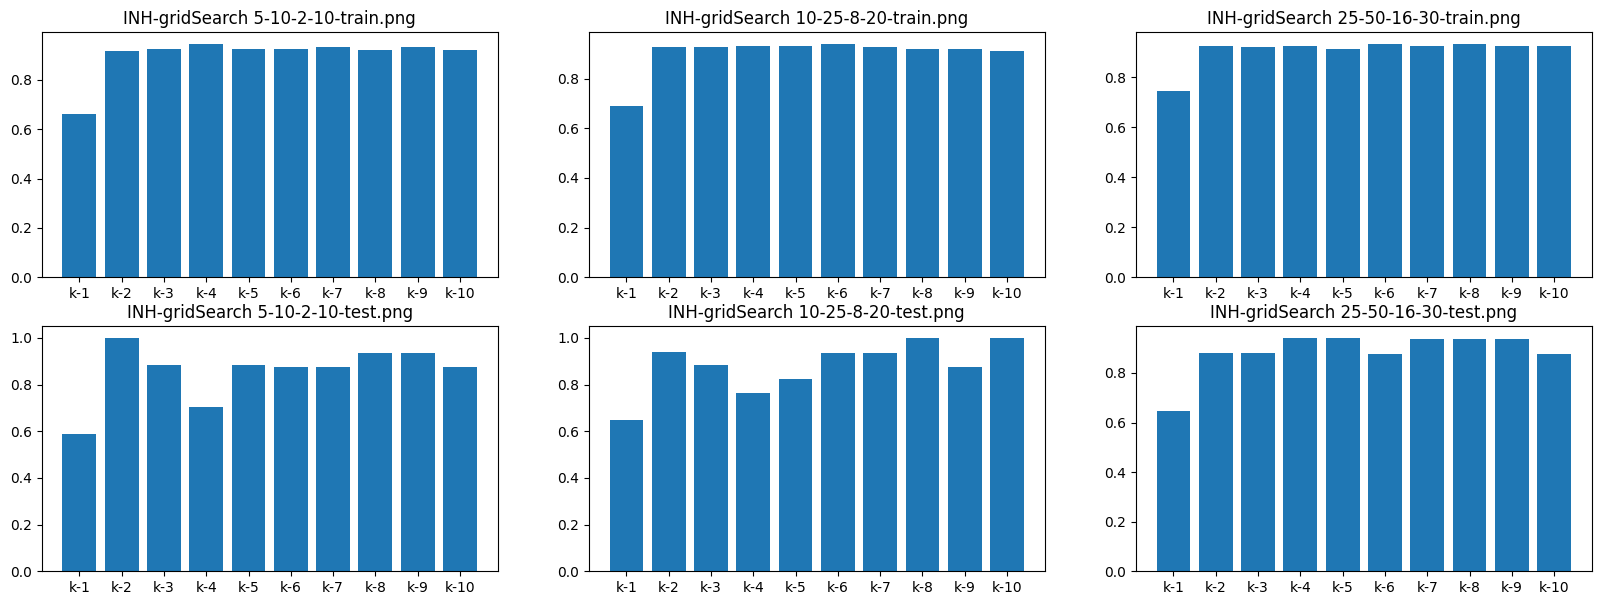

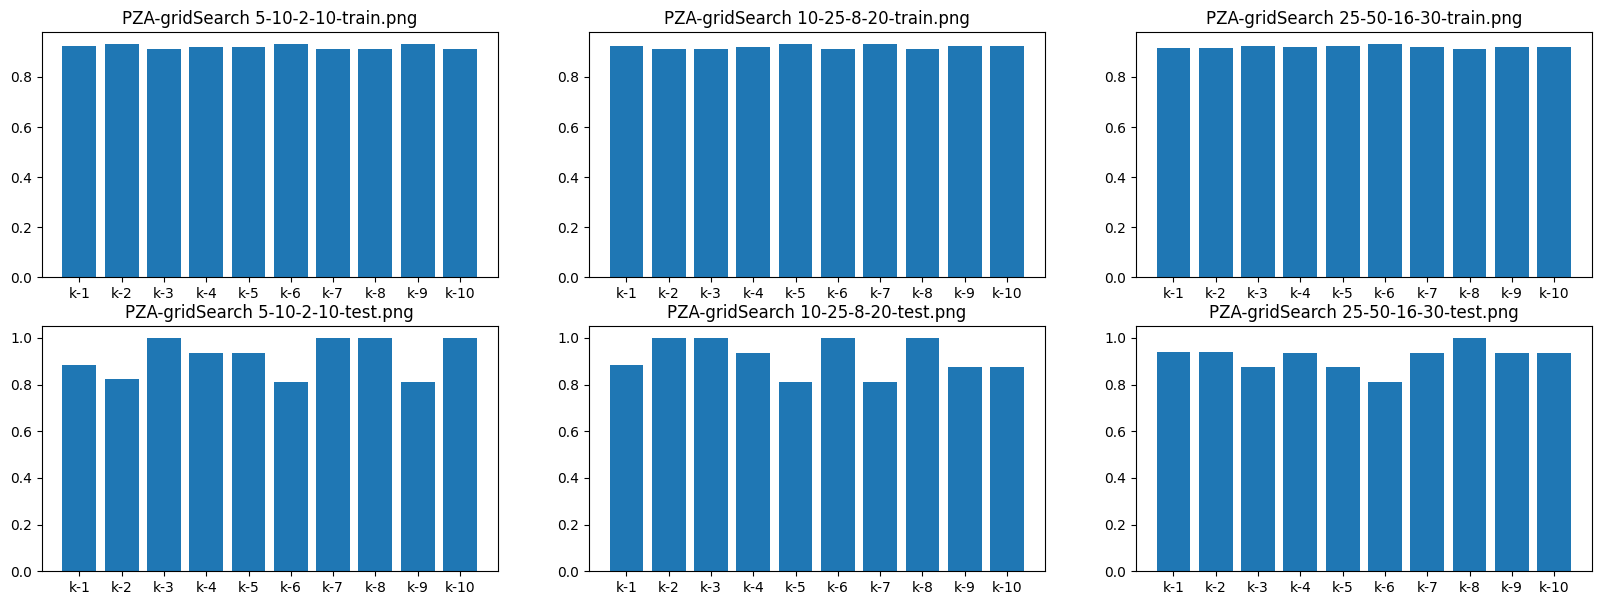

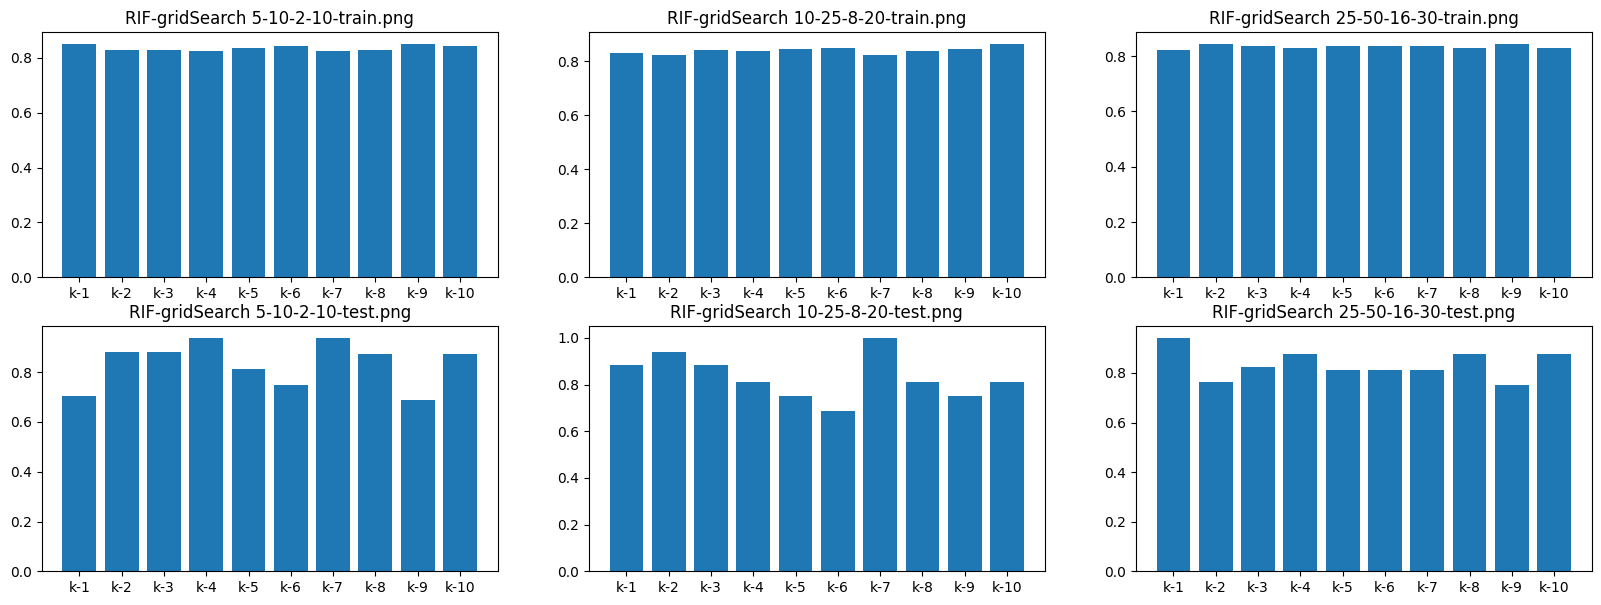

In [37]:
import matplotlib.pyplot as plt
from google.colab import files

print(result_type_gsearch_kcv_train)
print(result_type_gsearch_kcv_test)
print(np.array(result_type_gsearch_kcv_train).shape)

print("\n")

print(result_type_gsearch_avg_kcv_train)
print(result_type_gsearch_avg_kcv_test)
print(np.array(result_type_gsearch_avg_kcv_train).shape)

print("\n")

print(result_type_avg_gsearch_train)
print(result_type_avg_gsearch_test)
print(np.array(result_type_avg_gsearch_train).shape)


resistance_types = ['EMB', 'INH', 'PZA', 'RIF']
opt_n_estimators = [5,10,25]
opt_max_depth = [10,25,50]
opt_random_state = [2,8,16]
opt_min_samples_split = [10,20,30]

for type_idx, resistance in enumerate(resistance_types):
  fig_gridsearch_kfold, axs = plt.subplots(2, 3, figsize=(20, 7))
  for grid_idx, grid_search_result in enumerate(result_type_gsearch_kcv_train[type_idx]):  
    print(grid_idx,grid_search_result)
    title = f"gridSearch {str(opt_n_estimators[grid_idx])}-{str(opt_max_depth[grid_idx])}-{str(opt_random_state[grid_idx])}-{str(opt_min_samples_split[grid_idx])}"
    axs[0,grid_idx].bar(
        ["k-1","k-2","k-3","k-4","k-5","k-6","k-7","k-8","k-9","k-10"],
        grid_search_result
        )
    axs[0,grid_idx].set_title(f"{resistance}-{title}-train.png")
    axs[1,grid_idx].bar(
        ["k-1","k-2","k-3","k-4","k-5","k-6","k-7","k-8","k-9","k-10"],
        result_type_gsearch_kcv_test[type_idx][grid_idx]
        )
    axs[1,grid_idx].set_title(f"{resistance}-{title}-test.png")
  #plt.show()
  plt.savefig(f"{resistance}-gridSearch-w-10CV.png")
  files.download(f"{resistance}-gridSearch-w-10CV.png")


[[0.8017335852621634, 0.7989844119036372, 0.798308927727917], [0.9009250861599856, 0.9022855069834936, 0.9069970977689099], [0.9197638167217761, 0.9197496457250827, 0.9197496457250827], [0.8357189451122915, 0.8391109868604977, 0.8343537414965987]]
[[0.7830882352941176, 0.7536764705882353, 0.7709558823529411], [0.8558823529411764, 0.8808823529411764, 0.8856617647058822], [0.9205882352941177, 0.9194852941176471, 0.9194852941176471], [0.8345588235294118, 0.8330882352941178, 0.8341911764705883]]
(4, 3)
[[0.8017335852621634, 0.9009250861599856, 0.9197638167217761, 0.8357189451122915], [0.7989844119036372, 0.9022855069834936, 0.9197496457250827, 0.8391109868604977], [0.798308927727917, 0.9069970977689099, 0.9197496457250827, 0.8343537414965987]]
[[0.7830882352941176, 0.8558823529411764, 0.9205882352941177, 0.8345588235294118], [0.7536764705882353, 0.8808823529411764, 0.9194852941176471, 0.8330882352941178], [0.7709558823529411, 0.8856617647058822, 0.9194852941176471, 0.8341911764705883]]


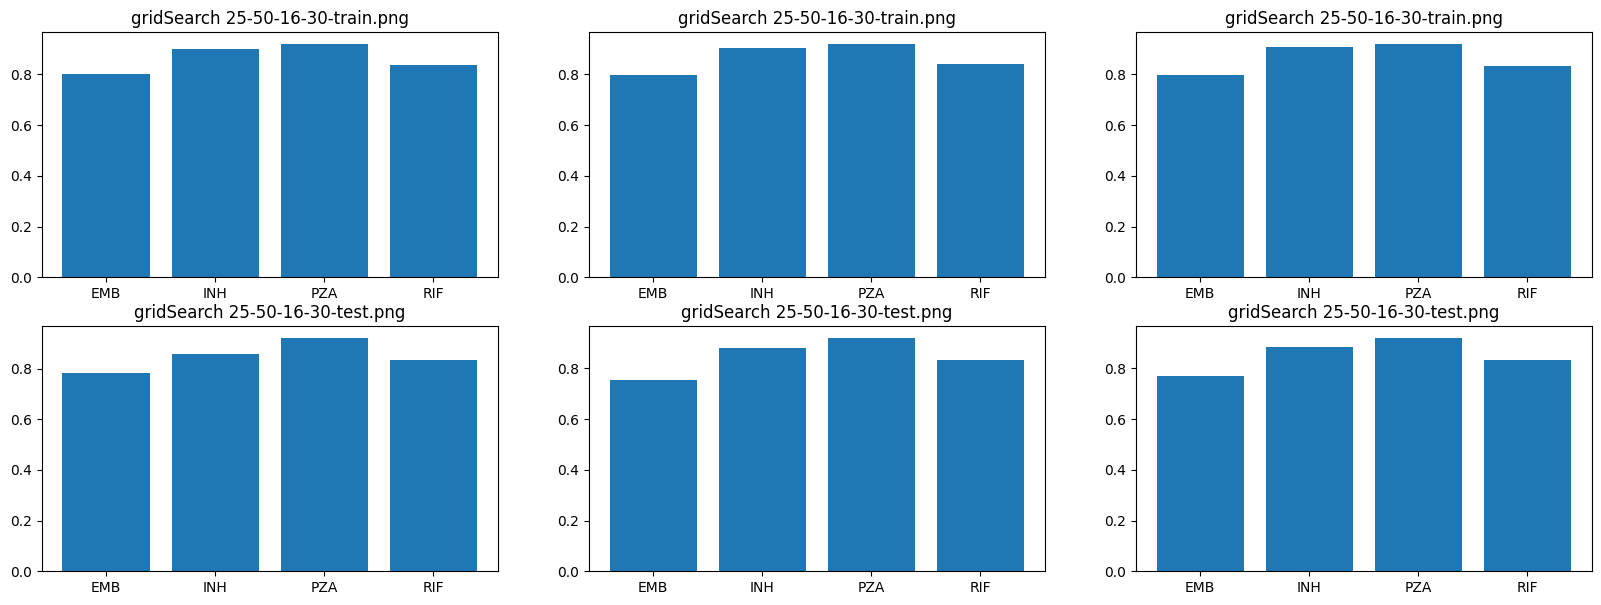

In [52]:
print(result_type_gsearch_avg_kcv_train)
print(result_type_gsearch_avg_kcv_test)
print(np.array(result_type_gsearch_avg_kcv_train).shape)

# print("\n")

# print(result_type_avg_gsearch_train)
# print(result_type_avg_gsearch_test)
# print(np.array(result_type_avg_gsearch_train).shape)

resistance_types = ['EMB', 'INH', 'PZA', 'RIF']
opt_n_estimators = [5,10,25]
opt_max_depth = [10,25,50]
opt_random_state = [2,8,16]
opt_min_samples_split = [10,20,30]

#fig_gridsearch, axs = plt.subplots(2, 3, figsize=(20, 7))
gridsearch_combination_train = []
gridsearch_combination_test = []
for grid_idx in range(len(opt_n_estimators)):
  temp_train = []
  temp_train.append(result_type_gsearch_avg_kcv_train[0][grid_idx])
  temp_train.append(result_type_gsearch_avg_kcv_train[1][grid_idx])
  temp_train.append(result_type_gsearch_avg_kcv_train[2][grid_idx])
  temp_train.append(result_type_gsearch_avg_kcv_train[3][grid_idx])
  gridsearch_combination_train.append(temp_train)

  temp_test = []
  temp_test.append(result_type_gsearch_avg_kcv_test[0][grid_idx])
  temp_test.append(result_type_gsearch_avg_kcv_test[1][grid_idx])
  temp_test.append(result_type_gsearch_avg_kcv_test[2][grid_idx])
  temp_test.append(result_type_gsearch_avg_kcv_test[3][grid_idx])
  gridsearch_combination_test.append(temp_test)

print(gridsearch_combination_train) 
print(gridsearch_combination_test)       

fig_gridsearch_kfold, axs = plt.subplots(2, 3, figsize=(20, 7))  
for type_idx, resistance in enumerate(gridsearch_combination_train):
  title = f"gridSearch {str(opt_n_estimators[grid_idx])}-{str(opt_max_depth[grid_idx])}-{str(opt_random_state[grid_idx])}-{str(opt_min_samples_split[grid_idx])}"
  axs[0,type_idx].bar(
      ['EMB', 'INH', 'PZA', 'RIF'],
      resistance
    )
  axs[0,type_idx].set_title(f"{title}-train.png")
  axs[1,type_idx].bar(
      ['EMB', 'INH', 'PZA', 'RIF'],
      gridsearch_combination_test[type_idx]
      )
  axs[1,type_idx].set_title(f"{title}-test.png")

plt.show()
#plt.savefig(f"{resistance}-gridSearch-w-10CV.png")
#files.download(f"{resistance}-gridSearch-w-10CV.png")

# Decision Tree from https://github.com/harrypnh/random-forest-from-scratch

In [ ]:
def trainTestSplit(dataFrame, testSize):
    if isinstance(testSize, float):
        testSize = round(testSize * len(dataFrame))
    indices = dataFrame.index.tolist()
    testIndices = random.sample(population = indices, k = testSize)
    dataFrameTest = dataFrame.loc[testIndices]
    dataFrameTrain = dataFrame.drop(testIndices)
    return dataFrameTrain, dataFrameTest

def checkPurity(data):
    if len(np.unique(data[:, -1])) == 1:
        return True
    else:
        return False

def classifyData(data):
    uniqueClasses, uniqueClassesCounts = np.unique(data[:, -1], return_counts = True)
    return uniqueClasses[uniqueClassesCounts.argmax()]

def getPotentialSplits(data, randomAttributes):
    potentialSplits = {}
    _, columns = data.shape
    columnsIndices = list(range(columns - 1))
    if randomAttributes != None  and len(randomAttributes) <= len(columnsIndices):
        columnsIndices = randomAttributes
    for column in columnsIndices:
        values = data[:, column]
        uniqueValues = np.unique(values)
        if len(uniqueValues) == 1:
            potentialSplits[column] = uniqueValues
        else:
            potentialSplits[column] = []
            for i in range(len(uniqueValues)):
                if i != 0:
                    currentValue = uniqueValues[i]
                    previousValue = uniqueValues[i - 1]
                    potentialSplits[column].append((currentValue + previousValue) / 2)
    return potentialSplits

def splitData(data, splitColumn, splitValue):
    splitColumnValues = data[:, splitColumn]
    return data[splitColumnValues <= splitValue], data[splitColumnValues > splitValue]

def calculateEntropy(data):
    _, uniqueClassesCounts = np.unique(data[:, -1], return_counts = True)
    probabilities = uniqueClassesCounts / uniqueClassesCounts.sum()
    return sum(probabilities * -np.log2(probabilities))

def calculateOverallEntropy(dataBelow, dataAbove):
    pDataBelow = len(dataBelow) / (len(dataBelow) + len(dataAbove))
    pDataAbove = len(dataAbove) / (len(dataBelow) + len(dataAbove))
    return pDataBelow * calculateEntropy(dataBelow) + pDataAbove * calculateEntropy(dataAbove)

def determineBestSplit(data, potentialSplits, randomSplits = None):
    overallEntropy = 9999
    bestSplitColumn = 0
    bestSplitValue = 0
    if randomSplits == None:
        for splitColumn in potentialSplits:
            for splitValue in potentialSplits[splitColumn]:
                dataBelow, dataAbove = splitData(data, splitColumn, splitValue)
                currentOverallEntropy = calculateOverallEntropy(dataBelow, dataAbove)
                if currentOverallEntropy <= overallEntropy:
                    overallEntropy = currentOverallEntropy
                    bestSplitColumn = splitColumn
                    bestSplitValue = splitValue
    else:
        for i in range(randomSplits):
            randomSplitColumn = random.choice(list(potentialSplits))
            randomSplitValue = random.choice(potentialSplits[randomSplitColumn])
            dataBelow, dataAbove = splitData(data, randomSplitColumn, randomSplitValue)
            currentOverallEntropy = calculateOverallEntropy(dataBelow, dataAbove)
            if currentOverallEntropy <= overallEntropy:
                overallEntropy = currentOverallEntropy
                bestSplitColumn = randomSplitColumn
                bestSplitValue = randomSplitValue
    return bestSplitColumn, bestSplitValue

def classifySample(sample, decisionTree):
    if not isinstance(decisionTree, dict):
        return decisionTree
    question = list(decisionTree.keys())[0]
    attribute, value = question.split(" <= ")
    if sample[attribute] <= float(value):
        answer = decisionTree[question][0]
    else:
        answer = decisionTree[question][1]
    return classifySample(sample, answer)

def calculateAccuracy(predictedResults, category):
    resultCorrect = predictedResults == category
    return resultCorrect.mean()

In [ ]:
def buildDecisionTree(dataFrame, currentDepth = 0, minSampleSize = 2, maxDepth = 1000, randomAttributes = None, randomSplits = None):
    if currentDepth == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = dataFrame.columns
        data = dataFrame.values
        if randomAttributes != None and randomAttributes <= len(COLUMN_HEADERS) - 1:
            randomAttributes = random.sample(population = list(range(len(COLUMN_HEADERS) - 1)), k = randomAttributes)
        else:
            randomAttributes = None
    else:
        data = dataFrame
    if checkPurity(data) or len(data) < minSampleSize or currentDepth == maxDepth:
        return classifyData(data)
    else:
        currentDepth += 1
        potentialSplits = getPotentialSplits(data, randomAttributes)
        splitColumn, splitValue = determineBestSplit(data, potentialSplits, randomSplits)
        dataBelow, dataAbove = splitData(data, splitColumn, splitValue)
        if len(dataBelow) == 0 or len(dataAbove) == 0:
            return classifyData(data)
        else:
            question = str(COLUMN_HEADERS[splitColumn]) + " <= " + str(splitValue)
            decisionSubTree = {question: []}
            yesAnswer = buildDecisionTree(dataBelow, currentDepth, minSampleSize, maxDepth, randomAttributes, randomSplits)
            noAnswer = buildDecisionTree(dataAbove, currentDepth, minSampleSize, maxDepth, randomAttributes, randomSplits)
            if yesAnswer == noAnswer:
                decisionSubTree = yesAnswer
            else:
                decisionSubTree[question].append(yesAnswer)
                decisionSubTree[question].append(noAnswer)
            return decisionSubTree

def decisionTreePredictions(dataFrame, decisionTree):
    predictions = dataFrame.apply(classifySample, axis = 1, args = (decisionTree,))
    return predictions

# Random Forest from https://github.com/harrypnh/random-forest-from-scratch

In [ ]:
def trainTestSplit(dataFrame, testSize):
    if isinstance(testSize, float):
        testSize = round(testSize * len(dataFrame))
    indices = dataFrame.index.tolist()
    testIndices = random.sample(population = indices, k = testSize)
    dataFrameTest = dataFrame.loc[testIndices]
    dataFrameTrain = dataFrame.drop(testIndices)
    return dataFrameTrain, dataFrameTest

def bootstrapSample(dataFrame, bootstrapSize):
    randomIndices = np.random.randint(low = 0, high = len(dataFrame), size = bootstrapSize)
    return dataFrame.iloc[randomIndices]

def createRandomForest(dataFrame, bootstrapSize, randomAttributes, randomSplits, forestSize = 20, treeMaxDepth = 1000):
    forest = []
    for i in range(forestSize):
        bootstrappedDataFrame = bootstrapSample(dataFrame, bootstrapSize)
        decisionTree = buildDecisionTree(bootstrappedDataFrame, maxDepth = treeMaxDepth, randomAttributes = randomAttributes, randomSplits = randomSplits)
        forest.append(decisionTree)
    return forest

def randomForestPredictions(dataFrame, randomForest):
    predictions = {}
    for i in range(len(randomForest)):
        column = "decision tree " + str(i)
        predictions[column] = decisionTreePredictions(dataFrame, randomForest[i])
    predictions = pd.DataFrame(predictions)
    return predictions.mode(axis = 1)[0]

def calculateAccuracy(predictedResults, category):
    resultCorrect = predictedResults == category
    return resultCorrect.mean()

# Test using amr data

In [ ]:
print("res_type short name list : emb, inh, pza, rif")
resistance_type = input("insert resistance type short name!\n")

# Read dataset.csv into dataframe
dataFrame = pd.read_csv(f'amr_datasets_r_{resistance_type}.csv')

# Drop phen_r_inh and accession_number feature (duplicate class in dataset.csv)
dataFrame = dataFrame.drop(f'phen_r_{resistance_type}', axis=1)
dataFrame = dataFrame.drop('!accession', axis=1)

# create LabelEncoder object
label_encoder = LabelEncoder()

# fit and transform the categorical variable
dataFrame['line_age'] = label_encoder.fit_transform(dataFrame['line_age'])

print(dataFrame)
dataFrameTrain, dataFrameTest = trainTestSplit(dataFrame, testSize = 0.4)

print("Random Forest - Breast Cancer Dataset")
print("  Maximum bootstrap size (n) is {}".format(dataFrameTrain.shape[0]))
print("  Maximum random subspace size (d) is {}".format(dataFrameTrain.shape[1] - 1))

print("\n  Change n, keep other parameters")
for i in range(10, dataFrameTrain.shape[0] + 1, 50):
    startTime = time.time()
    randomForest = createRandomForest(dataFrameTrain, bootstrapSize = i, randomAttributes = 10, randomSplits = 50, forestSize = 30, treeMaxDepth = 3)
    buildingTime = time.time() - startTime
    randomForestTestResults = randomForestPredictions(dataFrameTest, randomForest)
    accuracyTest = calculateAccuracy(randomForestTestResults, dataFrameTest.iloc[:, -1]) * 100
    randomForestTrainResults = randomForestPredictions(dataFrameTrain, randomForest)
    accuracyTrain = calculateAccuracy(randomForestTrainResults, dataFrameTrain.iloc[:, -1]) * 100
    print("  n = {}, d = {}, s = {}, k = {}, maxDepth = {}:".format(i, 10, 50, 30, 3))
    print("    accTest = {0:.2f}%, ".format(accuracyTest), end = "")
    print("accTrain = {0:.2f}%, ".format(accuracyTrain), end = "")
    print("buildTime = {0:.2f}s".format(buildingTime), end = "\n")

# print("\n  Change d, keep other parameters")
# for i in range(10, dataFrameTrain.shape[1], 2):
#     startTime = time.time()
#     randomForest = createRandomForest(dataFrameTrain, bootstrapSize = 60, randomAttributes = i, randomSplits = 50, forestSize = 30, treeMaxDepth = 3)
#     buildingTime = time.time() - startTime
#     randomForestTestResults = randomForestPredictions(dataFrameTest, randomForest)
#     accuracyTest = calculateAccuracy(randomForestTestResults, dataFrameTest.iloc[:, -1]) * 100
#     randomForestTrainResults = randomForestPredictions(dataFrameTrain, randomForest)
#     accuracyTrain = calculateAccuracy(randomForestTrainResults, dataFrameTrain.iloc[:, -1]) * 100
#     print("  n = {}, d = {}, s = {}, k = {}, maxDepth = {}:".format(60, i, 50, 30, 3))
#     print("    accTest = {0:.2f}%, ".format(accuracyTest), end = "")
#     print("accTrain = {0:.2f}%, ".format(accuracyTrain), end = "")
#     print("buildTime = {0:.2f}s".format(buildingTime), end = "\n")

print("\n  Change s, keep other parameters")
for i in range(10, 100 + 1, 10):
    startTime = time.time()
    randomForest = createRandomForest(dataFrameTrain, bootstrapSize = 60, randomAttributes = 10, randomSplits = i, forestSize = 30, treeMaxDepth = 3)
    buildingTime = time.time() - startTime
    randomForestTestResults = randomForestPredictions(dataFrameTest, randomForest)
    accuracyTest = calculateAccuracy(randomForestTestResults, dataFrameTest.iloc[:, -1]) * 100
    randomForestTrainResults = randomForestPredictions(dataFrameTrain, randomForest)
    accuracyTrain = calculateAccuracy(randomForestTrainResults, dataFrameTrain.iloc[:, -1]) * 100
    print("  n = {}, d = {}, s = {}, k = {}, maxDepth = {}:".format(60, 10, i, 30, 3))
    print("    accTest = {0:.2f}%, ".format(accuracyTest), end = "")
    print("accTrain = {0:.2f}%, ".format(accuracyTrain), end = "")
    print("buildTime = {0:.2f}s".format(buildingTime), end = "\n")

print("\n  Change k, keep other parameters")
for i in range(10, 100 + 1, 10):
    startTime = time.time()
    randomForest = createRandomForest(dataFrameTrain, bootstrapSize = 60, randomAttributes = 10, randomSplits = 50, forestSize = i, treeMaxDepth = 3)
    buildingTime = time.time() - startTime
    randomForestTestResults = randomForestPredictions(dataFrameTest, randomForest)
    accuracyTest = calculateAccuracy(randomForestTestResults, dataFrameTest.iloc[:, -1]) * 100
    randomForestTrainResults = randomForestPredictions(dataFrameTrain, randomForest)
    accuracyTrain = calculateAccuracy(randomForestTrainResults, dataFrameTrain.iloc[:, -1]) * 100
    print("  n = {}, d = {}, s = {}, k = {}, maxDepth = {}:".format(60, 10, 50, i, 3))
    print("    accTest = {0:.2f}%, ".format(accuracyTest), end = "")
    print("accTrain = {0:.2f}%, ".format(accuracyTrain), end = "")
    print("buildTime = {0:.2f}s".format(buildingTime), end = "\n")

res_type short name list : emb, inh, pza, rif
insert resistance type short name!
emb
     AAC_2___Ic_.  Erm_37__.  Mycobacterium_tuberculosis_Rv1258c_1_.  \
0               0          0                                       1   
1               0          0                                       1   
2               0          0                                       0   
3               0          0                                       0   
4               0          0                                       0   
..            ...        ...                                     ...   
157             0          0                                       1   
158             0          0                                       1   
159             0          0                                       1   
160             0          0                                       0   
161             0          0                                       1   

     Mycobacterium_tuberculosis_Rv1258c_1_S292L  \

KeyboardInterrupt: ignored

In [ ]:
# print all the index numbers of the DataFrame
print(sorted(dataFrame.index.tolist()))
print(label_encoder.classes_)
print(label_encoder.transform(label_encoder.classes_))
print("\n=======Train=======\n")
print(sorted(dataFrameTrain.index.tolist()))
# count the number of data points for each class
class_counts = dataFrameTrain[f'phen_{resistance_type}'].value_counts()
# print the class counts
print(class_counts)

print("\n=========Test=========\n")
print(sorted(dataFrameTest.index.tolist()))
# count the number of data points for each class
class_counts = dataFrameTest[f'phen_{resistance_type}'].value_counts()
# print the class counts
print(class_counts)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162]
['1' '2' '3' '4' '4 (Cameroon)' '4 (Haarlem)' '4 (LAM)' '4 (S-type)'
 '4 (Tur)' '4 (Uganda)' '4 (Ural)' '4 (X-type)' '6' 'M. bovis' 'M. orygis'
 nan]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

=======Train=======

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 18, 19, 21, 22, 23, 24, 28, 31, 